In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import geopandas as gpd
import heapq
import random
import timeit

from shapely.geometry import *

import sys
sys.path.append('./../exploration') # this is where the magic is going down
sys.path.append('./..')

from intersections_and_roads import *
from search import *
%matplotlib inline

In [2]:
bike_accidents = pd.read_csv('./../exploration/bicycle_crashes.csv')
bike_crashes_per_street = bike_accidents.groupby(['Street_ID'], as_index=False).size().reset_index()
bike_crashes_per_street.rename(index=str, inplace=True, columns={0: 'num_accidents'})

cb_elevation = pd.read_csv('../cambridgegis_data_trans/node_elevation_cambridge.csv', delimiter=' ', header=None, names=['id', 'elevation'])

intersections = gpd.read_file('../cambridgegis_data_trans/Intersections/TRANS_Intersections.topojson')
street_centerline = gpd.read_file('../cambridgegis_data_trans/Street_Centerlines/TRANS_Centerlines.topojson')
intersection_graph, connection_dict = build_intersection_graph(intersections=intersections, street_centerline=street_centerline, elevation=cb_elevation, accidents=bike_crashes_per_street)

In [5]:
## add costs of streets to connection_dic:

bike_accidents = pd.read_csv('./../exploration/bicycle_crashes.csv')
bike_crashes_per_street = bike_accidents.groupby(['Street_ID'], as_index=False).size().reset_index()
bike_crashes_per_street.rename(index=str, inplace=True, columns={0: 'num_accidents'})

In [6]:
bike_crashes_per_street.head()

,Street_ID,num_accidents
0,Aberdee_Ave_1,2
1,Aberdee_Ave_2,1
2,Albany_St_1,1
3,Albany_St_2,2
4,Albany_St_4,8


In [7]:
# add num accidents to each street id
for street in bike_crashes_per_street.itertuples():
    if connection_dict.get(street[1], None):
        connection_dict[street[1]].add_accidents(street[2])

In [8]:
# randomly select a start and an end point on the graph for test
start = intersection_graph[np.random.choice(intersection_graph.keys())]
end = intersection_graph[np.random.choice(intersection_graph.keys())]


In [19]:
# search the graph
route = a_star_search(start, end, intersection_graph, connection_dict, get_road_cost)
safe_route = a_star_search(start, end, intersection_graph, connection_dict, get_safe_road_cost)

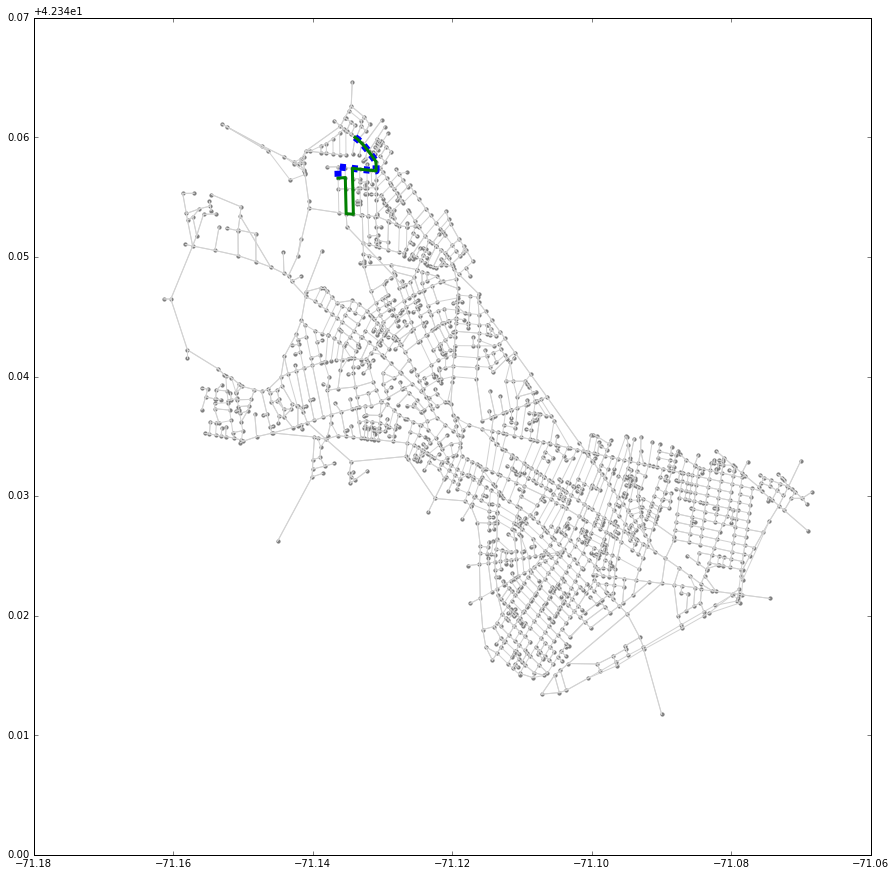

In [20]:
plot_graph(intersection_graph, connection_dict, [route['nodes']], [safe_route['nodes']])

In [21]:
p1 = intersection_graph[np.random.choice(intersection_graph.keys())]
p2 = intersection_graph[np.random.choice(intersection_graph.keys())]
p3 = intersection_graph[np.random.choice(intersection_graph.keys())]
p4 = intersection_graph[np.random.choice(intersection_graph.keys())]

centroid = simulated_annealing_b(intersection_graph,
                                 connection_dict,
                                 get_road_cost,
                                 null_heuristic,
                                 starting_points=[p1,p2,p3])

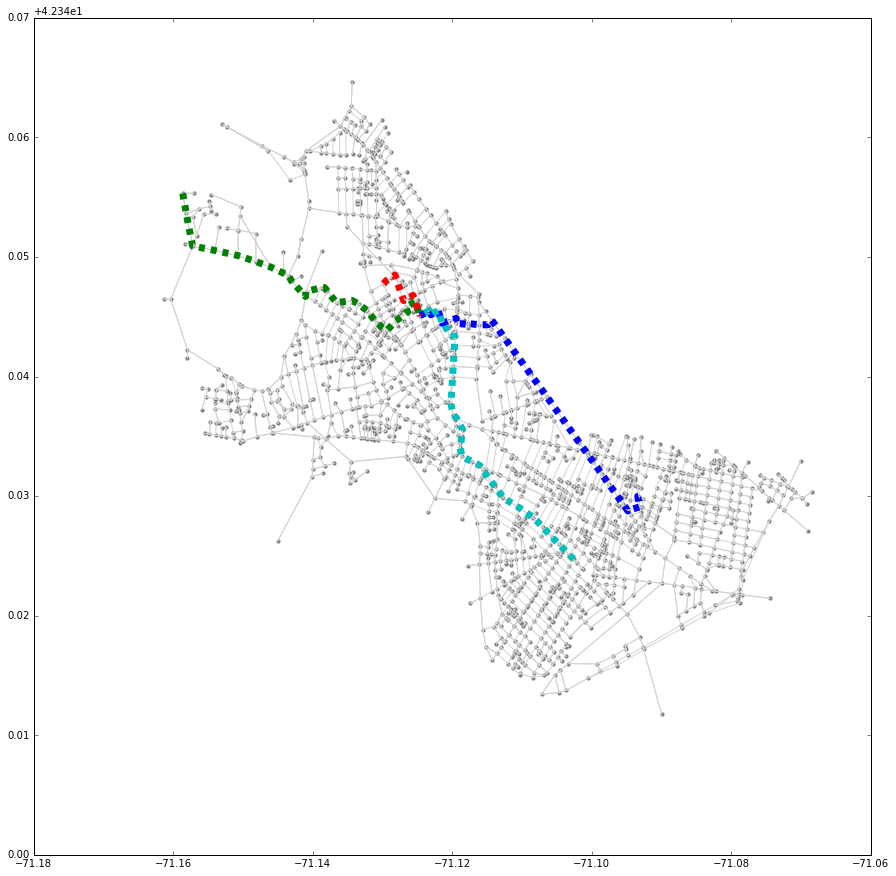

In [22]:
routes = []
connections = []
# fig, ax = plt.subplots(1,1, figsize=(15, 15))
for start in [p1,p2,p3,p4]:
    route = a_star_search(start, centroid, intersection_graph, connection_dict, get_road_cost)
    routes.append(route['nodes'])
    connections.append(route['connections'])

plot_graph(intersection_graph, connection_dict, routes, [])

In [ ]:
# # timing for comparing heuristics down the line
# def test():
# #     start = intersection_graph[np.random.choice(intersection_graph.keys())]
# #     end = intersection_graph[np.random.choice(intersection_graph.keys())]
#     a_star_search(start, end, intersection_graph)

# timeit.timeit("test()", setup="from __main__ import *", number=10)

Deal with elevation:

In [9]:
elevation = gpd.read_file('./../cambridgegis_data_trans/SpotElevations.geojson')
elevation.head(2)

,ELEV,TYPE,geometry
0,28.78,SPOT-RD-INT,POINT Z (-71.1199704241649 42.39099096795356 2...
1,29.90,SPOT-RD-INT,POINT Z (-71.11879996393426 42.39131624347542 ...


In [10]:
cb_elevation = pd.read_csv('../cambridgegis_data_trans/node_elevation_cambridge.csv', delimiter=' ', header=None, names=['id', 'elevation'])

In [11]:
cb_elevation['id'] = cb_elevation['id'].astype(int)
cb_elevation.head(5)

,id,elevation
0,1200,10.280483
1,344,29.700000
2,345,47.230000
3,346,37.540000
4,347,45.130000


In [40]:
intersections['id'] = intersections['id'].astype(int)

In [41]:
cb_elevation_points = cb_elevation.merge(intersections, on='id')

In [12]:
def elev(node):
#     print node
    point = Point(node.get_x_y()[0], node.get_x_y()[1])
    dist = [point.distance(elev_point) for elev_point in elevation['geometry']]
    clostest = np.argmin(dist)
    return elevation.iloc[clostest]['ELEV']

In [10]:
def elev(node, elevation):
#     print node
#     point = Point(node.get_x_y()[0], node.get_x_y()[1])
#     dist = [point.distance(elev_point) for elev_point in sf_elevation['point']]
#     closest = np.argmin(dist)
#     print int(node.id)
    return elevation[elevation['id']==int(node.id)]['elevation']

In [13]:
# node_elevation = []
for node in intersection_graph.values():
    node.set_elevation(elev(node))
#     node_elevation.append([node.id, node.elevation])

In [ ]:
# print len(node_elevation)
# np_elevation = np.array(node_elevation)
# np_elevation_float = np_elevation.astype('float64')

# print np_elevation_float.dtype

# np.savetxt("node_elevation_cambridge.csv", np_elevation_float)

In [ ]:
intersection_graph['1613'].get_elevation()

In [14]:
for connection in connection_dict:
#     print intersection_graph[connection_dict[connection].source].get_elevation()
    source_elev = intersection_graph[connection_dict[connection].source].get_elevation()
    target_elev = intersection_graph[connection_dict[connection].target].get_elevation()
    connection_dict[connection].set_delta_elevation(target_elev - source_elev)

In [15]:
np.max([node.get_elevation() for node in intersection_graph.values()])

71.989999999999995

In [16]:
intersections.head(2)

,EditDate,GlobalID,IntersectingStreetCount,Intersection,NodeNumber,P_X,P_Y,geometry,id
0,None,{D1E59B72-36DC-4E6B-9950-B9260BAA807C},2.0,Cardinal Medeiros Ave & James Way,1381.0,767108.65,2960261.64,POINT (-71.08945606491686 42.37037471967096),1174
1,None,{D18D1979-4869-4E5A-9D14-DC74ECDB7CBB},NaN,None,118.0,755424.60,2969559.46,POINT (-71.13254779801892 42.39603508437763),131


In [14]:
street_centerline.head(2).columns

Index([               u'Alias',            u'Direction',
                   u'EditDate',             u'FromNode',
                   u'GlobalID',               u'L_From',
                       u'L_To',                u'Label',
                  u'MajorRoad', u'Potentail_Range_Done',
           u'Potential_L_From',       u'Potential_L_To',
           u'Potential_R_From',       u'Potential_R_To',
                   u'ROADWAYS',               u'R_From',
                       u'R_To',          u'Restriction',
                     u'Street',            u'Street_ID',
                u'Street_Name',          u'Street_Type',
                     u'ToNode',             u'ZIP_Left',
                  u'ZIP_Right',             u'geometry',
                         u'id'],
      dtype='object')

In [17]:
import time

In [24]:
def get_road_cost(road_list, connection_list, intersection_graph, connection_dict):
    distance = 0
    for connection_id in connection_list:
        distance += connection_dict[connection_id].get_distance()
    return distance

def get_safe_road_cost(road_list, connection_list, intersection_graph, connection_dict):
    distance = 0
    for connection_id in connection_list:
        multiplier = 100
        weight = connection_dict[connection_id].get_accidents() + 1
        distance += (max(multiplier*connection_dict[connection_id].get_distance(), 1))**weight
    return distance

def get_safe_road_cost_with_elevation(road_list, connection_list, intersection_graph, connection_dict):
    distance = 0
    for connection_id in connection_list:
        multiplier = 10000
        weight = 5*connection_dict[connection_id].get_accidents() + 1
        distance += (max(multiplier*connection_dict[connection_id].get_distance(), 1))*weight
        distance += np.abs(connection_dict[connection_id].delta_elevation)
    return distance

In [25]:
bike_accidents = pd.read_csv('../exploration/bicycle_crashes.csv', delimiter=',')

In [32]:
begin = intersection_graph[np.random.choice(intersection_graph.keys())]
goal = intersection_graph[np.random.choice(intersection_graph.keys())]

In [33]:
start = time.time()
route = a_star_search(begin, goal, intersection_graph, connection_dict, get_road_cost)
end = time.time()
print 'Cost: Distance, Time: ', (end-start)
start = time.time()
safe_route = a_star_search(begin, goal, intersection_graph, connection_dict, get_safe_road_cost, null_heuristic)
end = time.time()
print 'Cost: Accidents + distance, Time: ', (end-start)
start = time.time()
safe_route_with_elevation = a_star_search(begin, goal, intersection_graph, connection_dict, get_safe_road_cost_with_elevation)
end = time.time()
print 'Cost: Accidents + distance + elevation, Time: ', (end-start)

Cost: Distance, Time:  0.467586040497
Cost: Accidents + distance, Time:  0.622769832611
Cost: Accidents + distance + elevation, Time:  0.849236965179


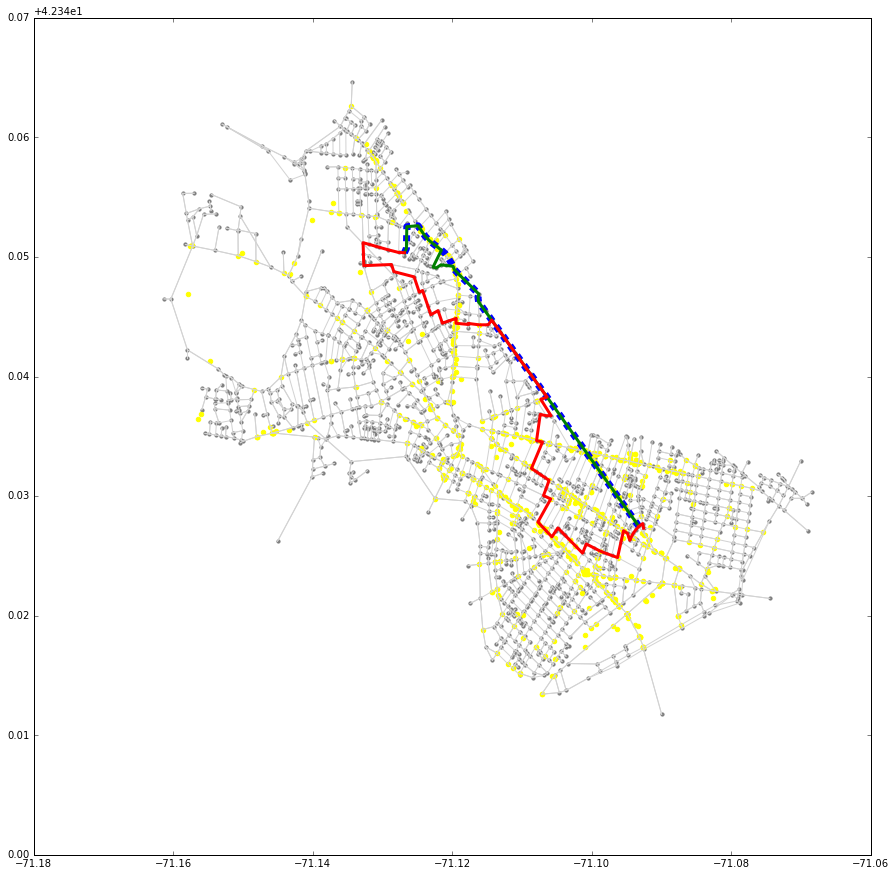

In [34]:
ax = plot_graph(intersection_graph, connection_dict, [route['nodes']], [safe_route['nodes'], safe_route_with_elevation['nodes']])
lat = bike_accidents[['Latitude']].values
lng = bike_accidents[['Longitude']].values
ax.scatter(lng, lat, color='yellow')

## Heuristic

In [35]:
start = time.time()
route = a_star_search(begin, goal, intersection_graph, connection_dict, get_safe_road_cost_with_elevation, null_heuristic)
end = time.time()
print 'null heuristic, Time: ', (end-start)
start = time.time()
route = a_star_search(begin, goal, intersection_graph, connection_dict, get_safe_road_cost_with_elevation, euclidean_heuristic)
end = time.time()
print 'euclidean heuristic, Time: ', (end-start)
start = time.time()
route = a_star_search(begin, goal, intersection_graph, connection_dict, get_safe_road_cost_with_elevation, combined_heuristic)
end = time.time()
print 'combined heuristic, Time: ', (end-start)

null heuristic, Time:  1.29996991158
euclidean heuristic, Time:  0.986067056656


ValueError: zero-size array to reduction operation minimum which has no identity